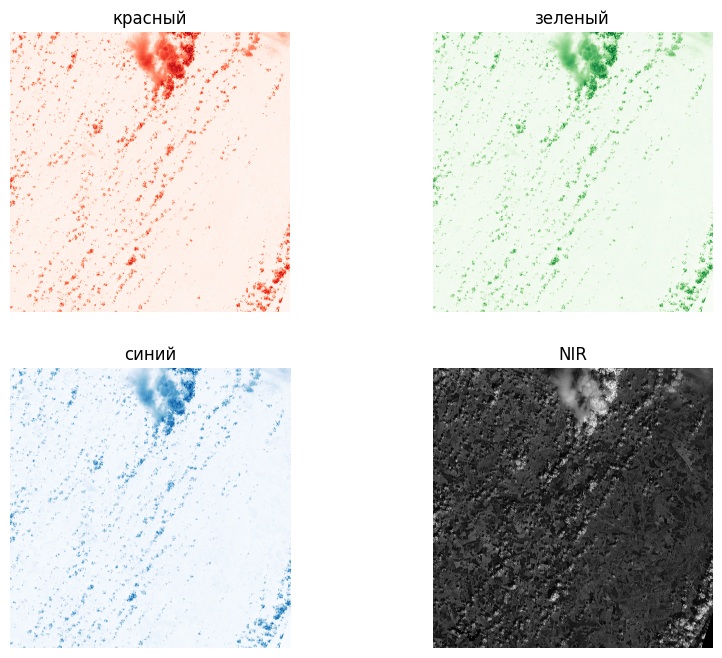

In [9]:
# открытие снимков

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2

from utils.image import load_multichannel_tiff_image

multichannel_tiff_image_path = '/Users/nikitakamenev/Documents/scince/DL_PROJECT/tiff_image/layout_2021-06-15.tif'

image_array = load_multichannel_tiff_image(multichannel_tiff_image_path)

if image_array.shape[-1] == 4:
    r_channel = image_array[:, :, 0]
    g_channel = image_array[:, :, 1]
    b_channel = image_array[:, :, 2]
    nir_channel = image_array[:, :, 3]

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('красный')
plt.imshow(r_channel, cmap='Reds')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('зеленый')
plt.imshow(g_channel, cmap='Greens')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('синий')
plt.imshow(b_channel, cmap='Blues')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('NIR')
plt.imshow(nir_channel, cmap='gray')
plt.axis('off')

plt.show()


In [10]:
# путь до большого изображения
large_image_path = "/Users/nikitakamenev/Documents/scince/DL_PROJECT/tiff_image/color_image.png"

# путь до кропа
crop_image_path = "/Users/nikitakamenev/Documents/scince/DL_PROJECT/tiff_image/cropped_image.png"

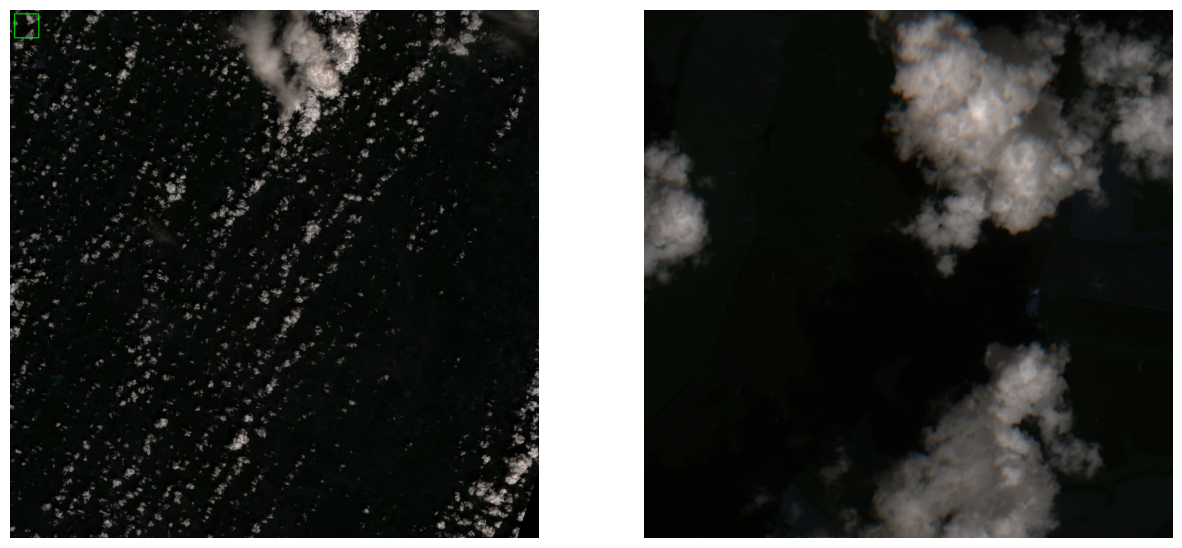

In [11]:
# поиск кропа в спутниковом снимке

import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils.find_features import get_keypoints_and_descriptors


def add_trans_descript(image, sift, keypoints_list, descriptors_list, transformations_list):
    transformations = [None, cv2.flip(image, 1)]
    for angle in range(0, 360, 90):
        for transform in transformations:
            if transform is not None:
                transformed_image = transform
            else:
                transformed_image = image
            rotated_image = cv2.rotate(transformed_image, cv2.ROTATE_90_CLOCKWISE) if angle != 0 else transformed_image
            kp, des = get_keypoints_and_descriptors(rotated_image, sift)
            keypoints_list.append(kp)
            descriptors_list.append(des)
            transformations_list.append((transform, angle))
    
    return keypoints_list, descriptors_list, transformations_list



large_image = cv2.imread(large_image_path) #1
# large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2GRAY)

large_image = cv2.resize(large_image, (3000, 3000))
crop_image = cv2.imread(crop_image_path) # 3
# crop_image = cv2.resize(crop_image, (64, 64))
# crop_image = cv2.flip(crop_image, 1)

sift = cv2.SIFT_create()

kp1, des1 = get_keypoints_and_descriptors(large_image, sift)

keypoints_list = []
descriptors_list = []
transformations_list = []
keypoints_list, descriptors_list, transformations_list = add_trans_descript(crop_image, sift, keypoints_list, descriptors_list, transformations_list)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
all_matches = []
for i, des2 in enumerate(descriptors_list):
    matches = bf.match(des1, des2)
    for match in matches:
        match.imgIdx = i
    all_matches.extend(matches)

all_matches = sorted(all_matches, key=lambda x: x.distance)

good_matches = all_matches[:50]

src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_list[m.imgIdx][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

h, w = crop_image.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)

large_image_with_box = cv2.polylines(large_image, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

fig, axes = plt.subplots(1, 2, figsize=(15, 15))

axes[0].imshow(cv2.cvtColor(large_image_with_box, cv2.COLOR_BGR2RGB))
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB))
axes[1].axis('off')

plt.show()